# Lab Assignment Four: Evaluation and Multi-Layer Perceptron

## Team Members
1. Piyush Metkar  - 47509180
2. Rishab Vaishya - 47505527
3. Dhaval Gogri   - 47444609


# 1. PREPARATION AND OVERVIEW

## 1.1 Business Understanding

The dataset **Grade Prediction** is taken from the Professor Moody Prediction dataset and it is about the behaviour of students and their grades they received in his class. Professor Moody observed various behavioural aspects of his students such as how much involvement they have in the class, how punctual are they and how much focus they had in the class. He quantified these aspects as 'never', 'rarely' and 'always'. He also added their grades to observe what impact their behaviour had on them. The dataset has a file with around 1000 instances.

The source of the dataset is as follows: https://www.kaggle.com/c/grade-prediction

The aim of this project is to predict the academic performance of students and **classify** them as per grades depending on their behaviour in class. The target class of this dataset is **Grades** column which is categorized in values A, B, C, D and F. 

We all know how much important the role of education is in the society. Analyzing some of the behavioral patterns of a student can help us gain an insight on their **academic performance of the future**. This information can be useful for faculty members to identify student which needs extra help with the course. It can be useful for parents who can predict how well their child is expected to perform in their academics. Students themseleves can also analyze their behavior and implement changes in order to increase their success chances.

On a broader level, It is useful for the university to know how their students are likely to behave & their competance against students of other universities. Since education is a vital part of the society in order to successfully mould the next generation of people. 

Many curious questions can be answered like reason for a students poor performance even after 100% attandance in the class. Percentage of people who manage to score good grades even after bunking a lot of lectures. Why do people score less even after clearing their doubts from professor. The results may not be what we generally assume.

Assuming human behaviour is more or less consistent in majority of societies & times. These predictions can be scaled to different regions and also can be used in the coming future.

## 1.2 Data Preparation & Description


In [490]:
import pandas as pd
import numpy as np

df = pd.read_csv('file:///Users/piyushmetkar/Documents/SMU/Notes/Spring 18/7324 Machine Learning in Python/Lab 4/moody_training_data.csv') 

df.head()

,STUDENTID,SCORE,GRADE,ASKSQUESTIONS,TEXTINGINCLASS,LATEINCLASS
0,65446,23.67,D,never,always,never
1,79686,8.41,F,never,never,rarely
2,56400,69.76,C,never,always,rarely
3,16792,95.51,A,never,always,always
4,92195,67.12,B,frequently,sometimes,never


We import the CSV data file into pandas dataframe object. We will extract the values of columns from df into numpy arrays required for classification.

The grades column is categorized as A, B, C, D and F as per the value of scores. We don't need the exact values of thier scores rather we are interested in grades. Hence we do not include the Score and StudentID columns.

The behaviour of the students such as do they use phones, do they ask questions and are they punctual are quantified in words 'never', 'sometimes', 'rarely', 'frequently' and 'always'. Based on their meaning, we can compare the words as follows since they are **ordinal**:

never < sometimes/rarely < frequently < always

Hence we replace these values with integers. 

We also replace all the grades in target class which is also of type **ordinal** with integers. Grades A, B, C, D and F are replaced by 0, 1, 2, 3 and 4 repectively. This will also help us to compare the grade.

Our dataset has **only 3 features** and hence we **don't need** to perform any **dimensionality reduction** technique on it. Also our data doesn't have any missing values.

In [491]:
df['ASKSQUESTIONS'].replace(['never', 'rarely', 'sometimes', 'frequently', 'always'], [0, 1, 1, 2, 3],inplace=True)
df['TEXTINGINCLASS'].replace(['never', 'rarely', 'sometimes', 'frequently', 'always'], [0, 1, 1, 2, 3],inplace=True)
df['LATEINCLASS'].replace(['never', 'rarely', 'sometimes', 'frequently', 'always'], [0, 1, 1, 2, 3],inplace=True)
df['GRADE'].replace(['A', 'B', 'C', 'D', 'F'], [0, 1, 2, 3, 4],inplace=True)


#ref : https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/
X = df.iloc[:, [3, 4, 5]].values
y = df['GRADE'].values

print(X.shape)
print(y.shape)


(998, 3)
(998,)


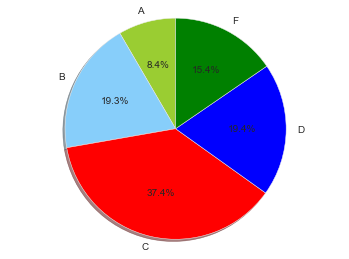

In [492]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

#ref: https://matplotlib.org/examples/pie_and_polar_charts/pie_demo_features.html
count_A = df.groupby('GRADE').count()

class_names = np.asarray(['A', 'B', 'C', 'D', 'F'])
labels = class_names
sizes = count_A.STUDENTID
colors = ['yellowgreen', 'lightskyblue', 'red', 'blue', 'green']
explode = (0.1, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.show()

As we can see the dataset follows a gaussian distribution i.e. majority of the instances fall under C & D target classes. Thus we have an imbalance distribution in our dataset with target class A having only 8% of instances. The distribution for these classes can be seen in the above pie chart.

Because of this imbalance distribution, the model won't be properly trained for target classes which have very less instances in training data. In order to avoid this problem we will perform sampling on training data

In [493]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Recall of raw data: 0.29438148348024223
F1-Score of raw data: 0.30013445658123317
(1490, 3)
Recall of over-sampled data: 0.36340461087499415
F1-Score of over-sampled data: 0.35702303362464816


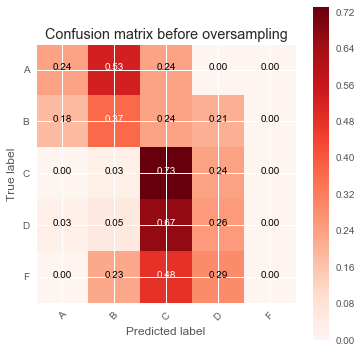

Cost of raw data: 12.512799872985632


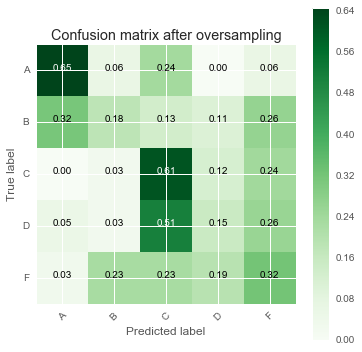

Cost of over-sampled data: 16.97741034091578


In [494]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.neural_network import MLPClassifier

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# these values have been hand tuned
clf = MLPClassifier(hidden_layer_sizes=(50, ), 
                    activation='logistic', 
                    solver='sgd', 
                    alpha=1e-4, # L2 penalty
                    batch_size='auto', # min of 200, num_samples
                    learning_rate='constant', 
                    learning_rate_init=0.1, # only SGD
                    power_t=0.5,    # only SGD
                    max_iter=255, 
                    shuffle=True, 
                    random_state=1, 
                    tol=1e-9, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    momentum=0.9, # only SGD
                    nesterovs_momentum=True, # only SGD
                    early_stopping=False, 
                    validation_fraction=0.1, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.999, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer


clf.fit(X_train,y_train)
yhat = clf.predict(X_test)
#print('Accuracy of raw data:',accuracy_score(yhat,y_test))
print('Recall of raw data:', recall_score(yhat,y_test, average='macro'))
print('F1-Score of raw data:', f1_score(yhat,y_test, average='macro'))
#print('Precision of raw data:', precision_score(yhat,y_test, average='macro'))
#print(mean_squared_error(yhat, y_test))

cost = [[ 0,  1,  2,  3,  5], 
        [ 2,  0,  1,  2,  5], 
        [ 4,  2,  0,  1,  4], 
        [ 6,  4,  2,  0,  4], 
        [25, 20, 15, 10,  0]]
        
#ref: http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.over_sampling.SMOTE.html
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12, ratio = 1)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train)
print(X_train_bal.shape)

clf.fit(X_train_bal,y_train_bal)
yhat_bal = clf.predict(X_test)

#print('Accuracy of over-sampled data:',accuracy_score(yhat_bal,y_test))
print('Recall of over-sampled data:', recall_score(yhat_bal,y_test, average='macro'))
print('F1-Score of over-sampled data:', f1_score(yhat_bal,y_test, average='macro'))
#print('Precision of raw data:', precision_score(yhat_bal,y_test, average='macro'))
#print(mean_squared_error(yhat_bal, y_test))

cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix before oversampling', cmap=plt.cm.Reds)
plt.show()

cnf_matrix = cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1)
print('Cost of raw data:', np.sum(np.multiply(cnf_matrix,cost)))

cnf_matrix = confusion_matrix(y_test, yhat_bal)
np.set_printoptions(precision=2)
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix after oversampling', cmap=plt.cm.Greens)
plt.show()
cnf_matrix = cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1)
print('Cost of over-sampled data:', np.sum(np.multiply(cnf_matrix,cost)))

These imbalances in our dataset can be solved using scikit-learn's SMOT method. This over-samples our training dataset & gives an equal weightage to all our classes.
After implementing this we can see that our prediction model does a far better job at predicting the classes with significant increase in recall and f-score for less weighted classes such as A and F.

# 2. EVALUATION 

## 2.1 Performance Metrics

To evaluate our model's performance we will be using **Recall, F1-Score and Weighted Error(Cost)** as metrics.

The reason for choosing each of the above evaluation metric is as follows:

**1. Recall:** Recall is direct function of false negatives in the predicted model. In our dataset it is important to not miss any false negatives. For example, a student who actually scores F grade in the class but is predicted to score an A grade will result in not giving proper attention to the student. Had the grade of the student was predicted as F, the teacher could have guided him and pursuaded him to focus and study more the class.
Thus the wrong prediction for fail would result in student taking the class again which is the worst case for this dataset defeating the purpose of this prediction model. So it is important to have minimum the number of false negatives in the predicted model which can be observed by calculating recall. Higher the value of recall, lower the number of false negatives.

**2. F1-Score:** As we want false negative to be minimum which is determined by recall, we also want to minimize false positive even though prediction of a false positive may not be as costly. So we would want to consider f1 score for our prediction model as it will help us anaylse the effects of false positive in our model. For example, if a student who scores an A grade but is predicted to score a D or F may bring unnecessary stress to the student and may demotivate him due to lack of appreciation. As we can see this may not be as bad as getting false negative prediction, still it is needed for a good prediction model. Higher the value of F1 score, lower the cose of false negatives as well as false positives. 

Higher values of both recall and f1-scores also indicates that we get a high values of true positives too with our model.

**3. Weighted Error(Cost):** 
Weighted error gives more comprehensive information about error in prediction. Here we are using a cost matrix with custom values to emphasize the seriousness of an error in prediction. The cost matrix is given below and we can see that error of predicting a false A grade as F grade has the most weights because this is the most expensive false negative in the errors which is explained above. Likewise, a false prediction B as A will not really make much of a difference and hence it adds considerbly less weight to the error of prediction. 
** Thus we can consider the weighted error (cost) matrix as a single value to evaluate the performace of the model as a whole**




Cost Matrix


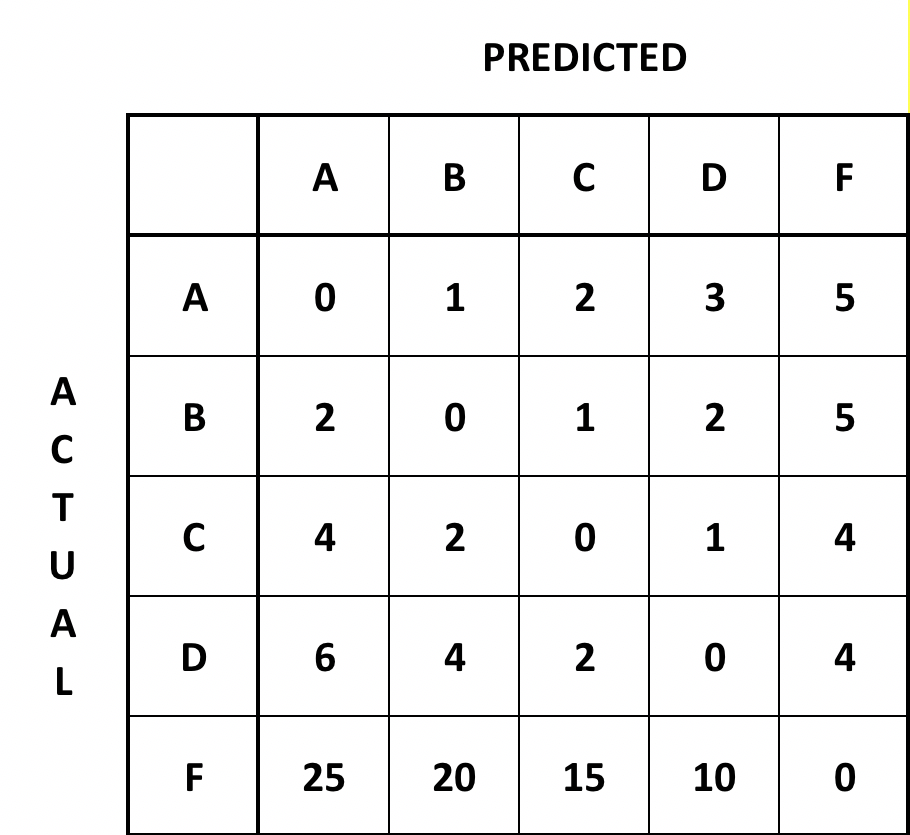

In [495]:
from IPython.display import Image
print('Cost Matrix')
PATH = "/Users/piyushmetkar/Documents/SMU/Notes/Spring 18/7324 Machine Learning in Python/Lab 4/Cost_Matrix.png"
Image(filename = PATH, width=350, height=250)

## 2.2 Data Division


In order to prepare our model so that it predict proper output classes, we need to train our data. This means that we need to provide few training samples as an input for our model and for output it tests it's predicting capabilities on our test datas. Thus we have decided to split our entire data set into training and testing data. This can be done by many ways like 
1. using holdout where you reserve x% of our data set for training and (100-x)% for testing. 
2. using random sampling where there is a repeatition of holdout with reserve x% of data being replaced on every iteration.
3. using cross validation where we partition dataset into k disjoit subsets & then use 1 of the subset as a test set and remaining as training set.
but for a model with unequal distribution of target classes this may not work as it is possible that 1 sunset or X% of data might not contain a perticular target class or may contain only few target classes out of many.

4. Stratified K-Folds cross-validator provides train/test indices to split data in train/test sets.
This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class, this keeping the overall class distribution same. stratified K-Folds also provides all functionalities provided by Holdout, random sampling & k-fold cross validation. So we decided to go forward with Stratified K-Folds cross-validator to split our dataset.

reference : http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

In our model, since we have around a thousand instances we've kept 20 percent of the data as test and remaining 80 percent as training data. This gives us a balanced distribution for our dataset and good enough quantity and quality 
for our model to train on.

# 3. MODELING

## 3.1 Custom Implementation of Multi-Layer Perceptron
This is our base class of multi layer implementation class which has the following important inputs as paramters
<br>application = our activation or phi function to be used.
<br>cost = quadratic or cross entropy.
<br>n_layers = the number of hidden layers in our model.

In [496]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import sys
import pandas as pd

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class MultiLayerPerceptronBase(object):
    def __init__(self, n_neurons=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None, n_layers = 3, application = 'sigmoid', cost = 'quadratic'):
        np.random.seed(random_state)
        self.n_neurons = n_neurons
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.n_hidden_layers = n_layers
        self.n_layers = n_layers + 1
        self.application = application
        self.cost = cost
        self.totalCost = 0
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _random_weights(self, layer, n_hidden_layers, n_features_):
        if layer != 'output_layer':
            bound = np.sqrt(6 / (n_hidden_layers + n_features_ + 1))
            w = np.random.uniform(-bound, bound, (n_hidden_layers, n_features_+1))
        else:
            bound = np.sqrt(0.5 / (n_hidden_layers + n_features_ + 1))
            w = np.random.uniform(-bound, bound, (n_hidden_layers, n_features_+1))
        return w
    
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    
    def _cost(self,A,Y_enc):
        '''Get the objective function value'''
        if self.cost == 'quadratic':
            cost_list = np.mean((Y_enc-A)**2)
        if self.cost == 'cross entropy':
            cost_list = -np.mean(Y_enc * np.log(A) + (1-Y_enc) * np.log(1 - A))

        return cost_list
    

This class implements from MultiLayer Perceptron Base class and does the necessary function implementation as shown

In [497]:
class MultiLayerPerceptron(MultiLayerPerceptronBase):
    def _feedforward(self, X):
        A_list = []
        Z_list = []
        
        A = self._add_bias_unit(X, how='column').T
        A_list.append(A)
        
        for i in range(self.n_layers - 1):
            Z = self.W[i] @ A
            if self.application == "relu" :
                temp = Z * (Z > 0)
            if self.application == 'sigmoid':
                temp = expit(Z)
            if self.application == "silu" :
                temp = Z * expit(Z)
            if self.application == "linear" :
                temp = Z
                
            A = self._add_bias_unit(temp, how='row')
            Z_list.append(Z)
            A_list.append(A)
        Z = self.W[self.n_layers - 1] @ A
        A = expit(Z)
        
        Z_list.append(Z)
        A_list.append(A)

        return A_list, Z_list
    
    def _initialize_weights(self):

        W = []        
        W.append(self._random_weights(self.application, self.n_neurons, self.n_features_))            
        for i in range(1, self.n_layers-1):
            W.append(self._random_weights(self.application, self.n_neurons, self.n_neurons))                
        W.append(self._random_weights('output_layer', self.n_output_, self.n_neurons))
            
        self.W = W
        self.grad_list = self.W.copy()
    
    #ref: https://github.com/carterkoehler/evaluation-and-mlp/blob/master/notebooks/cover-type.ipynb with major modifications 
    def _get_gradient(self, A, Z, Y_enc):
        W_copy = self.W.copy()
        

        if self.cost == 'quadratic':
            W_copy[-1] = -2 * (Y_enc - A[-1]) * (1 - A[-1])
        elif self.cost == 'cross entropy':
            W_copy[-1] = (A[-1] - Y_enc)
        
        self.grad_list[-1] = W_copy[-1] @ A[-2].T
        self.grad_list[-1] += self.W[-1] * self.l2_C
        
        for i in range(-2, -self.n_layers, -1):
            if self.application == "sigmoid" :
                temp = A[i] * (1 - A[i])
            if self.application == 'relu':
                temp = np.ones(A[i].shape) * (A[i] > 0)
            if self.application == "silu" :
                temp = expit(A[i]) + A[i] * expit(A[i]) * (1 - expit(A[i]))
            if self.application == "linear" :
                temp = np.ones(A[i].shape)
                
            if i == -2:
                W_copy[i] = (temp * (self.W[i+1].T @ W_copy[i+1]))
            else:
                W_copy[i] = (temp * (self.W[i+1].T @ W_copy[i+1][1:,:]))
                
            self.grad_list[i] = W_copy[i][1:,:] @ A[i-1].T
            self.grad_list[i][:,1:] += self.W[i][:,1:] * self.l2_C
        
    
    def predict(self, X):
        """Predict class labels"""
        A, Z = self._feedforward(X)
        y_pred = np.argmax(A[-1], axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y_data)
        
        # init weights and setup matrices
        self.n_features_ = X.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A, Z = self._feedforward(X_data)
            
            # compute gradient via backpropagation
            self._get_gradient(A, Z, Y_enc)
            
            cost_list = self._cost(A[-1], Y_enc)
            self.cost_.append(cost_list)
            self.totalCost = self.totalCost + self.cost_[i]
            for j in range(self.n_layers): 
                self.W[j] -= self.eta * self.grad_list[j]
        
        return self

In [498]:
params = dict(n_neurons=100, 
              C=1, # tradeoff L2 regularizer
              epochs=100, # iterations
              eta=0.00001,  # learning rate
              random_state=1,
              n_layers = 5, application = 'sigmoid', cost = 'quadratic')

In [499]:
%%time 
mlp = MultiLayerPerceptron(**params)
mlp.fit(X_train_bal, y_train_bal, print_progress=10)
yhat = mlp.predict(X_test)

cnf_matrix = confusion_matrix(y_test, yhat)
cnf_matrix = cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1)
print('Cost', np.sum(np.multiply(cnf_matrix,cost)))

Epoch: 100/100

Cost 18.447216618396084
CPU times: user 2.35 s, sys: 266 ms, total: 2.62 s
Wall time: 1.9 s


## 3.2 Hyper-Parameter Tuning & Metrics Visualizations
The following code are just for visaualization different cost, recall scores and f1 scores depending on the paramters we choose and comparing all the activations methods side by sode ni a bar graph to give us an idea pf the their performance.

In [500]:
phi_function = ['sigmoid', 'linear', 'relu', 'silu']
objective_function = ['quadratic', 'cross entropy']
no_of_layers = [1,2,7]
all_combination = []

store_recall_value = []
store_f1_value = []
store_cost_matrix_value = []

In [501]:
for i in range(len(phi_function)):
    for j in range(len(objective_function)):
            for k in range(len(no_of_layers)):
                
                print(phi_function[i], ' ', objective_function[j], ' ', no_of_layers[k])
                params = dict(n_neurons=100, 
                C=1, # tradeoff L2 regularizer
                epochs=100, # iterations
                eta=0.00001,  # learning rate
                random_state=1,
                n_layers = no_of_layers[k], application = phi_function[i], cost = objective_function[j])
                
                mlp = MultiLayerPerceptron(**params)
                mlp.fit(X_train_bal, y_train_bal, print_progress=100)
                yhat = mlp.predict(X_test)

                
                print('Cost of over-sampled data:', mlp.totalCost)
                print('Recall of raw data:', recall_score(yhat,y_test, average='macro'))
                print('F1-Score of raw data:', f1_score(yhat,y_test, average='macro'))
                print()
                
                store_recall_value.append(recall_score(yhat,y_test, average='macro'))
                store_f1_value.append(f1_score(yhat,y_test, average='macro'))
                store_cost_matrix_value.append(mlp.totalCost)
                all_combination.append(phi_function[i] + ' ' + objective_function[j] + ' ' + str(no_of_layers[k]))
                

                

sigmoid   quadratic   1


Epoch: 100/100

Cost of over-sampled data: 16.38992431773795
Recall of raw data: 0.3265464434114264
F1-Score of raw data: 0.2413700413700414

sigmoid   quadratic   2


Epoch: 100/100/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Cost of over-sampled data: 16.543116727490446
Recall of raw data: 0.09446652638142
F1-Score of raw data: 0.11582750763909191

sigmoid   quadratic   7


Epoch: 100/100

Cost of over-sampled data: 16.47430863896196
Recall of raw data: 0.1136612504415401
F1-Score of raw data: 0.09157045152038894

sigmoid   cross entropy   1


Epoch: 100/100

Cost of over-sampled data: 51.10011062394069
Recall of raw data: 0.1917936507936508
F1-Score of raw data: 0.16382536382536383

sigmoid   cross entropy   2


Epoch: 100/100

Cost of over-sampled data: 51.40852257144675
Recall of raw data: 0.08924408924408925
F1-Score of raw data: 0.10666405847564275

sigmoid   cross entropy   7


Epoch: 100/100

Cost of over-sampled data: 51.26971648900045
Recall of raw data: 0.038
F1-Score of raw data: 0.0638655462184874

linear   quadratic   1
Cost of over-sampled data: 16.88939286090617
Recall of raw data: 0.20186778895193766
F1-Score of raw data: 0.23777465777465778

linear   quadratic   2


Epoch: 100/100

Cost of over-sampled data: 16.526997374877144
Recall of raw data: 0.26883219954648524
F1-Score of raw data: 0.2970113835731269

linear   quadratic   7


Epoch: 100/100

Cost of over-sampled data: 15.263990971754977
Recall of raw data: 0.25682540197020387
F1-Score of raw data: 0.2846974522292994

linear   cross entropy   1
Cost of over-sampled data: 52.49545897283799
Recall of raw data: 0.20186778895193766
F1-Score of raw data: 0.23777465777465778

linear   cross entropy   2


Epoch: 100/100

Cost of over-sampled data: 51.61181176427469
Recall of raw data: 0.267195974280123
F1-Score of raw data: 0.2962207970682547

linear   cross entropy   7


Epoch: 100/100

Cost of over-sampled data: 48.24451270493259
Recall of raw data: 0.30043836082706515
F1-Score of raw data: 0.3008333333333334

relu   quadratic   1
Cost of over-sampled data: 17.63080474017302
Recall of raw data: 0.19135703766042497
F1-Score of raw data: 0.20324987963408764

relu   quadratic   2


Epoch: 100/100

Cost of over-sampled data: 18.313805232881627
Recall of raw data: 0.13997186081097715
F1-Score of raw data: 0.17508281573498966

relu   quadratic   7


Epoch: 100/100

Cost of over-sampled data: 19.208913374738326
Recall of raw data: 0.14236608111038823
F1-Score of raw data: 0.14639360522784292

relu   cross entropy   1
Cost of over-sampled data: 54.31363383652078
Recall of raw data: 0.09890102077091056
F1-Score of raw data: 0.1299864773495605

relu   cross entropy   2


Epoch: 100/100

Cost of over-sampled data: 55.84117479832256
Recall of raw data: 0.13059130969460955
F1-Score of raw data: 0.16882456140350877

relu   cross entropy   7


Epoch: 100/100

Cost of over-sampled data: 58.078595675839296
Recall of raw data: 0.038
F1-Score of raw data: 0.0638655462184874

silu   quadratic   1


Epoch: 100/100

Cost of over-sampled data: 18.642433639290402
Recall of raw data: 0.2670313491902697
F1-Score of raw data: 0.2303533850495591

silu   quadratic   2


Epoch: 100/100

Cost of over-sampled data: 20.243220353156705
Recall of raw data: 0.1149945999018164
F1-Score of raw data: 0.15360745614035087

silu   quadratic   7


Epoch: 100/100

Cost of over-sampled data: 21.394505930766123
Recall of raw data: 0.075
F1-Score of raw data: 0.10909090909090909

silu   cross entropy   1


Epoch: 100/100

Cost of over-sampled data: 56.75775676768628
Recall of raw data: 0.09308865047995482
F1-Score of raw data: 0.1250335871025526

silu   cross entropy   2


Epoch: 100/100

Cost of over-sampled data: 60.250841911957835
Recall of raw data: 0.1149945999018164
F1-Score of raw data: 0.15360745614035087

silu   cross entropy   7


Epoch: 100/100

Cost of over-sampled data: 62.454466450978
Recall of raw data: 0.075
F1-Score of raw data: 0.10909090909090909



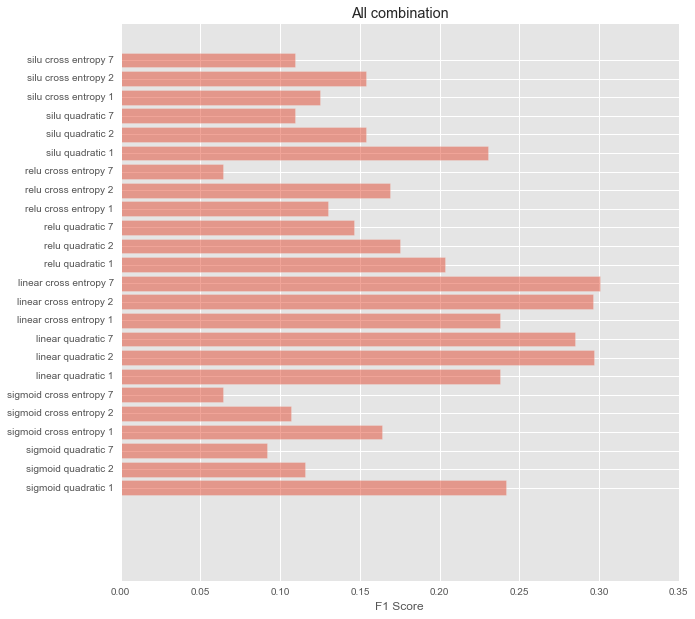

In [503]:
 
y_pos = np.arange(len(all_combination))

plt.figure(figsize=(10, 10)) 
plt.barh(y_pos, store_f1_value, align='center', alpha=0.5)
plt.yticks(y_pos, all_combination)
plt.xlabel('F1 Score')
plt.title('All combination')
 
plt.show()

The above bar graph shows all the combination of hyper-parameters along with the F1 score that we get.
By looking at the bar graph above we can find that the linear functin works the best among all other functions i.e. sigmoid, ReLU and SiLU to get the best F1 Score. Linear gives almost the same result with Cross Entrpy and Mean Swaure Error which is a quadratic objective function.

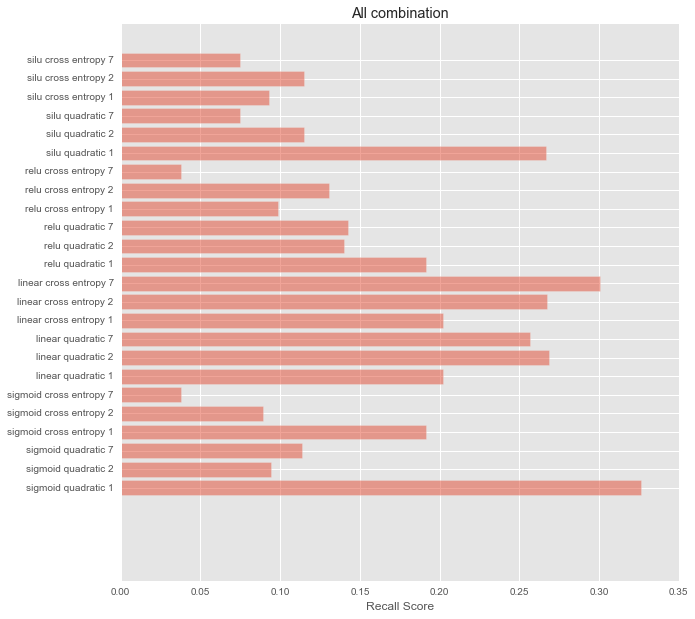

In [504]:
y_pos = np.arange(len(all_combination))

plt.figure(figsize=(10, 10)) 
plt.barh(y_pos, store_recall_value, align='center', alpha=0.5)
plt.yticks(y_pos, all_combination)
plt.xlabel('Recall Score')
plt.title('All combination')
 
plt.show()

The above bar graph shows all the combination of hyper-parameters along with the Recall score that we get.
By looking at the bar graph above we can find that the linear functin works the best among all other functions i.e. sigmoid, ReLU and SiLU to get the best Recall Score in terms of getting better score at a high frequency. Linear gives almost the same result with Cross Entrpy and Mean Swaure Error which is a quadratic objective function.

Epoch: 70/1000

cross entropy    linear    1
Costs as per our confusion metrics 23.672748913591818
Recall of raw data: 0.2553424012311055
F1-Score of raw data: 0.2709590643274854


Epoch: 100/100

cross entropy    sigmoid    1
Costs as per our confusion metrics 22.481108046718752
Recall of raw data: 0.2446084107350676
F1-Score of raw data: 0.2545647840531562
cross entropy    relu    1
Costs as per our confusion metrics 23.672748913591818
Recall of raw data: 0.2553424012311055
F1-Score of raw data: 0.2709590643274854


Epoch: 100/100

cross entropy    silu    1
Costs as per our confusion metrics 22.4021606782977
Recall of raw data: 0.25559742172407857
F1-Score of raw data: 0.2716350019708317


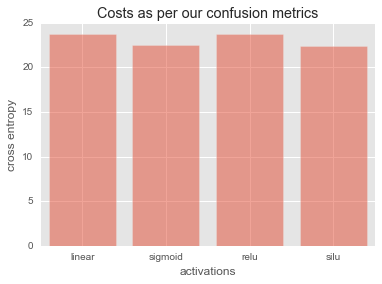

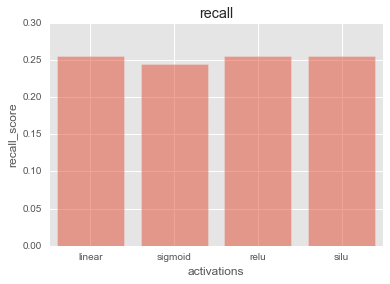

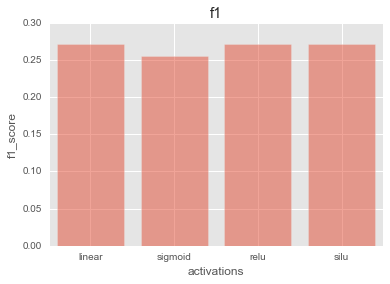

Epoch: 80/1000

quadratic    linear    1
Costs as per our confusion metrics 23.672748913591818
Recall of raw data: 0.2553424012311055
F1-Score of raw data: 0.2709590643274854


Epoch: 100/100

quadratic    sigmoid    1
Costs as per our confusion metrics 22.481108046718752
Recall of raw data: 0.2446084107350676
F1-Score of raw data: 0.2545647840531562
quadratic    relu    1
Costs as per our confusion metrics 23.672748913591818
Recall of raw data: 0.2553424012311055
F1-Score of raw data: 0.2709590643274854


Epoch: 100/100

quadratic    silu    1
Costs as per our confusion metrics 22.728476467771387
Recall of raw data: 0.2566713048855906
F1-Score of raw data: 0.2723149965308752


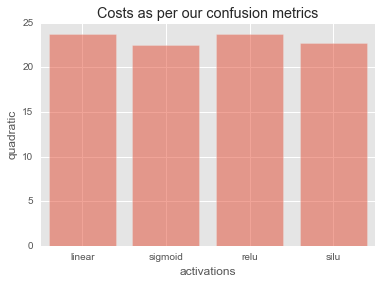

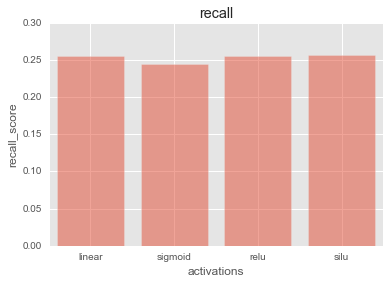

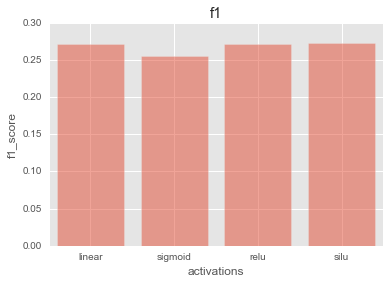

In [505]:
applications = ['linear', 'sigmoid' ,'relu', 'silu']
y_pos = np.arange(len(applications))
performance = [10,8,6,4,2,1]

for cost_temp in ['cross entropy', 'quadratic']:
    save_cost = np.zeros(len(applications))
    save_recall = np.zeros(len(applications))
    save_f1 = np.zeros(len(applications))
    i=0
    for appli in applications:
        
        n_layers = 1
        params = dict(n_neurons=100, 
              C=1, # tradeoff L2 regularizer
              epochs=100, # iterations
              eta=0.0001,  # learning rate
              random_state=1,
              n_layers = n_layers, application = appli, cost = cost_temp)

        mlp = MultiLayerPerceptron(**params)
        mlp.fit(X_train_bal, y_train_bal, print_progress=10)
        yhat = mlp.predict(X_test)
        cnf_matrix = confusion_matrix(y_test, yhat)
        cnf_matrix = cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1)
        print(cost_temp,"  ",appli, "  ", n_layers)
        save_cost[i] = np.sum(np.multiply(cnf_matrix,cost))
        save_recall[i] = recall_score(yhat,y_test, average='macro')
        save_f1[i] = f1_score(yhat,y_test, average='macro')
        print('Costs as per our confusion metrics',save_cost[i])
        print('Recall of raw data:', save_recall[i])
        print('F1-Score of raw data:',save_f1[i])
        i=i+1
    
    plt.bar(y_pos, save_cost, align='center', alpha=0.5)
    plt.xticks(y_pos, applications)
    plt.xlabel('activations')
    plt.ylabel(cost_temp)
    plt.title("Costs as per our confusion metrics")
    plt.show()
    
    plt.bar(y_pos, save_recall, align='center', alpha=0.5)
    plt.xticks(y_pos, applications)
    plt.xlabel('activations')
    plt.ylabel('recall_score')
    plt.title('recall')
    plt.show()
    
    plt.bar(y_pos, save_f1, align='center', alpha=0.5)
    plt.xticks(y_pos, applications)
    plt.xlabel('activations')
    plt.ylabel('f1_score')
    plt.title('f1')
    plt.show()
    

In [439]:
Neurons = np.zeros(100)
F1Scores = np.zeros(100)
Costs = np.zeros(100)

for i in range(100):
    Neurons[i] = i+1
    params = dict(n_neurons=i+1, 
              C=1, # tradeoff L2 regularizer
              epochs=100, # iterations
              eta=0.00001,  # learning rate
              random_state=1,
              n_layers = 5, application = 'sigmoid', cost = 'quadratic')
    
    mlp = MultiLayerPerceptron(**params)
    mlp.fit(X_train_bal, y_train_bal, print_progress=10)
    yhat = mlp.predict(X_test)
    
    F1Scores[i] = f1_score(yhat,y_test, average='macro')
    cnf_matrix = confusion_matrix(y_test, yhat)
    cnf_matrix = cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1)
    Costs[i] = np.sum(np.multiply(cnf_matrix,cost))

Epoch: 100/100/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
Epoch: 100/100

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  This is separate from the ipykernel package so we can avoid doing imports until
No handles with labels found to put in legend.


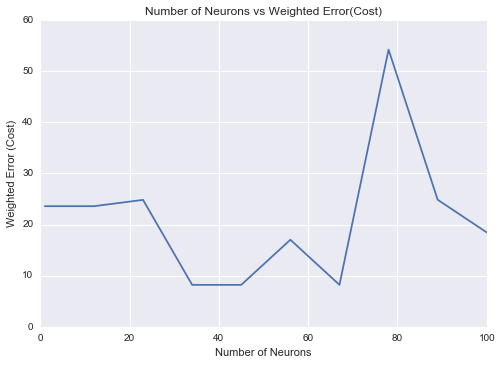

In [466]:
from scipy.interpolate import spline
x_smooth = np.linspace(Neurons.min(), Neurons.max(), 10)
y_smooth = spline(Neurons, Costs, x_smooth)
plt.style.use('seaborn')
plt.plot(x_smooth, y_smooth)
plt.title('Number of Neurons vs Weighted Error(Cost)')
plt.xlim(0,100)
plt.ylim(0,)
plt.xlabel('Number of Neurons')
plt.ylabel('Weighted Error (Cost)')
plt.legend(loc='best')
plt.show()



Here we are comparing the performance of MLP in terms of Weighted Error(Cost) against different number of neurons deployed in the model. There is no consistent pattern that is observed but we get the least error for around 70 neurons.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  
No handles with labels found to put in legend.


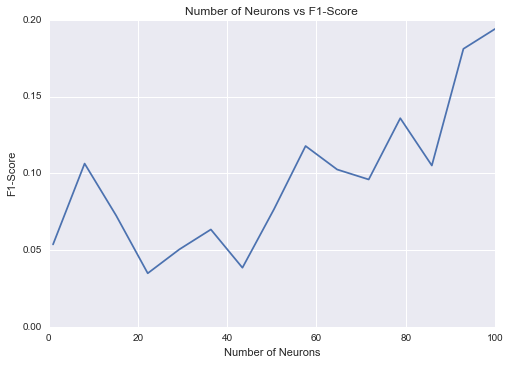

In [465]:
x_smooth = np.linspace(Neurons.min(), Neurons.max(), 15)
y_smooth = spline(Neurons, F1Scores, x_smooth)
plt.style.use('seaborn')
plt.plot(x_smooth, y_smooth)
plt.title('Number of Neurons vs F1-Score')
plt.xlim(0,100)
plt.ylim(0,)
plt.xlabel('Number of Neurons')
plt.ylabel('F1-Score')
plt.legend(loc='best')
plt.show()

Here we are comparing the performance of MLP in terms of F1-Score against different number of neurons deployed in the model. The F1-Score goes on increasing as we increase the number of neurons in each layer. Thus this results in decrease in false negatives and false positives.

In [476]:
heatmap_f1 = np.zeros((10, 10))
heatmap_Costs = np.zeros((10, 10))
heatmap_Recall = np.zeros((10, 10))

for i in range(10):
#neurons
    for j in range(10):
    #epochs
    
        params = dict(n_neurons=(i+1)*10, 
              C=1, # tradeoff L2 regularizer
              epochs=(j+1)*10, # iterations
              eta=0.00001,  # learning rate
              random_state=1,
              n_layers = 5, application = 'sigmoid', cost = 'quadratic')
    
        mlp = MultiLayerPerceptron(**params)
        mlp.fit(X_train_bal, y_train_bal, print_progress=10)
        yhat = mlp.predict(X_test)

        heatmap_f1[i][j] = f1_score(yhat,y_test, average='macro')*100
        heatmap_Recall[i][j] = recall_score(yhat,y_test, average='macro')
        cnf_matrix = confusion_matrix(y_test, yhat)
        cnf_matrix = cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1)
        heatmap_Costs[i][j] = np.sum(np.multiply(cnf_matrix,cost))

Epoch: 10/10/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
Epoch: 30/30

(10, 10)


Epoch: 100/100

Heatmap : X axis - No. of Neurons, Y axis - Epochs | Value - Weighted Error


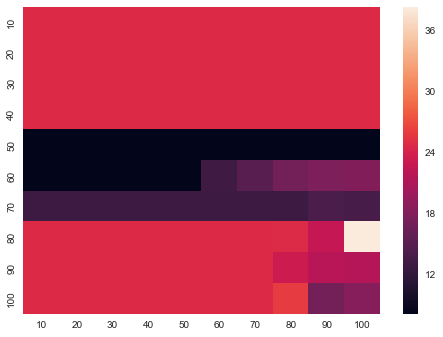

In [484]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()

ax.set_xlabel('Neurons')
ax.set_ylabel('Epochs')
yticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#xticks = 
ax = sns.heatmap(heatmap_Costs, yticklabels=yticks, xticklabels=yticks)
print('Heatmap : X axis - No. of Neurons, Y axis - Epochs | Value - Weighted Error')

Here we are looking at heatmap of the Weighted Error and how it performs with respect to number of neurons and epochs. As we can see the least error occurs at 50 epochs and for 10-50 neurons.

Heatmap : X axis - No. of Neurons, Y axis - Epochs | Value - F1-Score


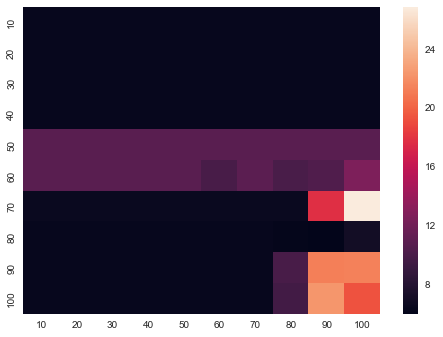

In [485]:
ax.set_xlabel('Neurons')
ax.set_ylabel('Epochs')
yticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#xticks = 
ax = sns.heatmap(heatmap_f1, yticklabels=yticks, xticklabels=yticks)
print('Heatmap : X axis - No. of Neurons, Y axis - Epochs | Value - F1-Score')

Here the highest F1-Score is acheived at 100 neurons and 70 epochs

Heatmap : X axis - No. of Neurons, Y axis - Epochs | Value - Recall


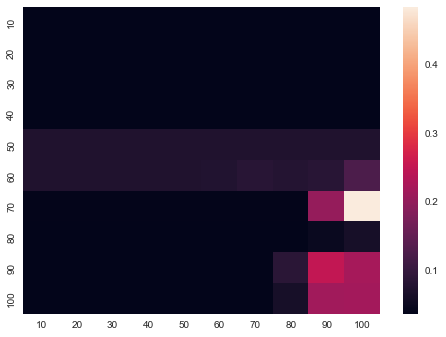

In [486]:
ax.set_xlabel('Neurons')
ax.set_ylabel('Epochs')
yticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#xticks = 
ax = sns.heatmap(heatmap_Recall, yticklabels=yticks, xticklabels=yticks)
print('Heatmap : X axis - No. of Neurons, Y axis - Epochs | Value - Recall')

As we can see from the graph that most of the area has low recall around less number of neurons and epochs. As we increase epochs and neurons to 70 & 100 respectively, we see increase in recall rate upto more than 40%.

## 3.3 Visualizing gradients for each layer

In [507]:
params = dict(n_neurons=30, 
              C=1, # tradeoff L2 regularizer
              epochs=100, # iterations
              eta=0.00001,  # learning rate
              random_state=1,
              n_layers = 7, application = 'silu', cost = 'cross entropy')

mlp = MultiLayerPerceptron(**params)
mlp.fit(X_train_bal, y_train_bal, print_progress=10)
yhat = mlp.predict(X_test)



Epoch: 100/100

In [565]:
print(len(mlp.grad_list[0]))
print(mlp.grad_list[1][0][10])


30
-0.23627624690542795


-0.2066794850325112 : 0.2819537655198111
-0.0878653553743708 : 0.09847802734869442
-0.11249226051335816 : 0.07169486468126494
-0.10577405820008581 : 0.09193612965738412
-0.13673937748164314 : 0.21472043390505058
-0.28138057955166434 : 0.17494870857253936
-0.561561213351435 : 0.32613507122129803


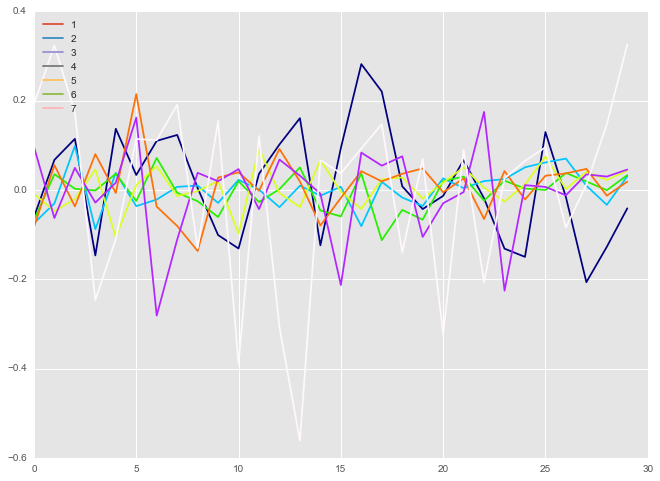

In [569]:
def getMean(list):
    X = np.zeros(30)
    

    for i in range(len(list)):
        sum = 0
        for j in range(len(list[0])):
            sum += list[i][j]
        X[i] = sum/len(list[0])
    print(np.min(X), ':', np.max(X))
    return X

Xp = np.zeros(30)
for i in range(30):
    Xp[i] = i
    
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)

ax1.plot(Xp, getMean(mlp.grad_list[0]), label=1)
ax1.plot(Xp, getMean(mlp.grad_list[1]), label=2)
ax1.plot(Xp, getMean(mlp.grad_list[2]), label=3)
ax1.plot(Xp, getMean(mlp.grad_list[3]), label=4)
ax1.plot(Xp, getMean(mlp.grad_list[4]), label=5)
ax1.plot(Xp, getMean(mlp.grad_list[5]), label=6)
ax1.plot(Xp, getMean(mlp.grad_list[6]), label=7)

ax1.legend(loc=2)

colormap = plt.cm.gist_ncar 
colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])


The X axis represents the mean of each row for the gradient vector of a layer. The y axis is the value of gradients. From the graph above, it is evident that the gradients after each layer fluctuates but float around the value 0. Yes the gradient stays more or less consistent for each layer.

# 4. Exceptional Work

From the above visuals of bar graphs and the statistics, we see that how every activations methods compare themselves in thier different evaluation metrics

These results are obtained after taking many combination of values of eta, n_layers, c for our model.
After that it was found that

<br> for the first 3 graphs we see the comparision when having cost as **cross entropy**
<br> where cost of **relu** being the highest and **sigmoid** being the lowest
<br> recall score of **sigmoid** being the lowest and the rest giving around same scores 
<br> f1 score of  **sigmoid** being the lowest and the rest giving around same scores 
<br>  
<br> for the remaining 3 graphs we see the comparision when having cost as **quadratic**
<br> where cost of  **sigmoid** being the lowest and the rest giving around same scores 
<br> recall score of  **sigmoid** being the lowest and the rest giving around same scores 
<br> f1 score of  **sigmoid** being the lowest and the rest giving around same scores 
Overall we observe a constant trend between all our comparisions between evaluation metrics and hyper-paramters.

So for our model we can go ahead using **Sigmoid weighted Linear unit (Silu)** and cost being cross entropy as it gives consistant good performance with lower cost.